In [13]:
# Basic imports
import numpy as np
import pandas as pd
import time
import os

# Machine learning libraries
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from bayes_opt import BayesianOptimization

# Additional tools
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [14]:
# Load data
data = pd.read_excel('data.xlsx', sheet_name='data')
# Separate features and labels
X = data.iloc[:, :28]  # 前28列作为特征
y = data.iloc[:, 29]   # 后1列作为标签

# Dataset partitioning
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)  # 0.125 x 0.8 = 0.1

In [15]:
# Define objective function for Bayesian Optimization
def bayesopt_objective(learning_rate, n_estimators, max_depth, num_leaves, feature_fraction, bagging_fraction, bagging_freq, lambda_l1, lambda_l2):
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'num_leaves': int(num_leaves),
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': int(bagging_freq),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'random_state': 1412,
        'verbose': -1,  # Use -1 for no logging, or set to an integer for verbose level
        'n_jobs': -1
    }

    reg = lgb.LGBMRegressor(**params)

    cv = KFold(n_splits=5, shuffle=True, random_state=1412)
    scores = cross_validate(
        reg, X_train, y_train,
        scoring=["neg_root_mean_squared_error", "r2"],
        cv=cv,
        verbose=False,
        n_jobs=-1
    )

    # Return the mean of RMSE and R2
    mean_rmse = np.mean(scores['test_neg_root_mean_squared_error'])
    mean_r2 = np.mean(scores['test_r2'])

    print(f"RMSE: {-mean_rmse:.4f}, R2: {mean_r2:.4f}")

    return -mean_rmse  # We want to minimize RMSE, so we return its negative

In [16]:
# Define parameter space
param_grid_simple = {
    'learning_rate': (0.001, 1.0),
    'n_estimators': (50, 100),
    'max_depth': (1, 50),
    'num_leaves': (2, 100),
    'feature_fraction': (0.1, 1),
    'bagging_fraction': (0.1, 1),
    'bagging_freq': (1, 5),
    'lambda_l1': (1e-2, 1),
    'lambda_l2': (1e-3, 1e-2)
}

In [17]:
# Bayesian Optimization process
def param_bayes_opt(init_points, n_iter):
    opt = BayesianOptimization(
        f=bayesopt_objective,
        pbounds=param_grid_simple,
        random_state=1412
    )

    opt.maximize(
        init_points=init_points,
        n_iter=n_iter
    )

    # Display the results of each iteration
    for i, res in enumerate(opt.res):
        params = res['params']
        rmse = -res['target']
        r2 = res.get('mean_test_r2', None)  # Adjust if R2 is not available
        r2_str = f"{r2:.4f}" if r2 is not None else "N/A"
        print(f"Iteration {i + 1}: Params: {params}, RMSE: {rmse:.4f}, R2: {r2_str}")

    score_best = opt.max["target"]
    params_best = opt.max["params"]

    print("\nBest params:", params_best)
    print("Best RMSE score:", -score_best)

    return params_best, -score_best


In [18]:
# Execute optimization
start = time.time()
params_best, score_best = param_bayes_opt(2, 3)
print('Optimization time: %.2f minutes' % ((time.time() - start) / 60))

|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
RMSE: 0.6755, R2: 0.7602
| 1         | 0.6755    | 0.8918    | 4.008     | 0.1574    | 0.4449    | 0.00388   | 0.7612    | 46.15     | 93.96     | 40.29     |
RMSE: 0.4592, R2: 0.8893
| 2         | 0.4592    | 0.6003    | 2.065     | 0.4589    | 0.277     | 0.007158  | 0.06837   | 24.81     | 79.02     | 91.89     |
RMSE: 0.3992, R2: 0.9164
| 3         | 0.3992    | 0.8324    | 3.03      | 0.4484    | 0.5043    | 0.004949  | 0.3931    | 45.82     | 94.07     | 39.65     |
RMSE: 0.3872, R2: 0.9213
| 4         | 0.3872    | 0.3669    | 3.667     | 0.2746    | 0.3933    | 0.003596  | 0.4773    | 37.31     | 88.93     | 23.87     |
RMSE: 0.1213, R2: 0.9923
| 5         | 0.1213    | 0.181     | 1.667     | 0.754     | 0.3686   


Validation RMSE with best params: 0.5571616820732821

Feature Importances:
Sa10    0.902504
Hc      0.056188
Lm      0.021750
ρl      0.007889
η       0.002613
Ha      0.001613
fc      0.001198
Kd      0.001006
Δl      0.000605
mf      0.000495
ξ       0.000431
Kfr     0.000403
fy      0.000365
Δt      0.000335
Kp      0.000284
ρt      0.000280
Kft     0.000268
μb      0.000263
Ask     0.000259
Dw      0.000257
Kp.1    0.000246
W       0.000213
Ks      0.000205
Kr      0.000112
Rs      0.000079
Vv      0.000075
Ec      0.000034
BT      0.000030
dtype: float64


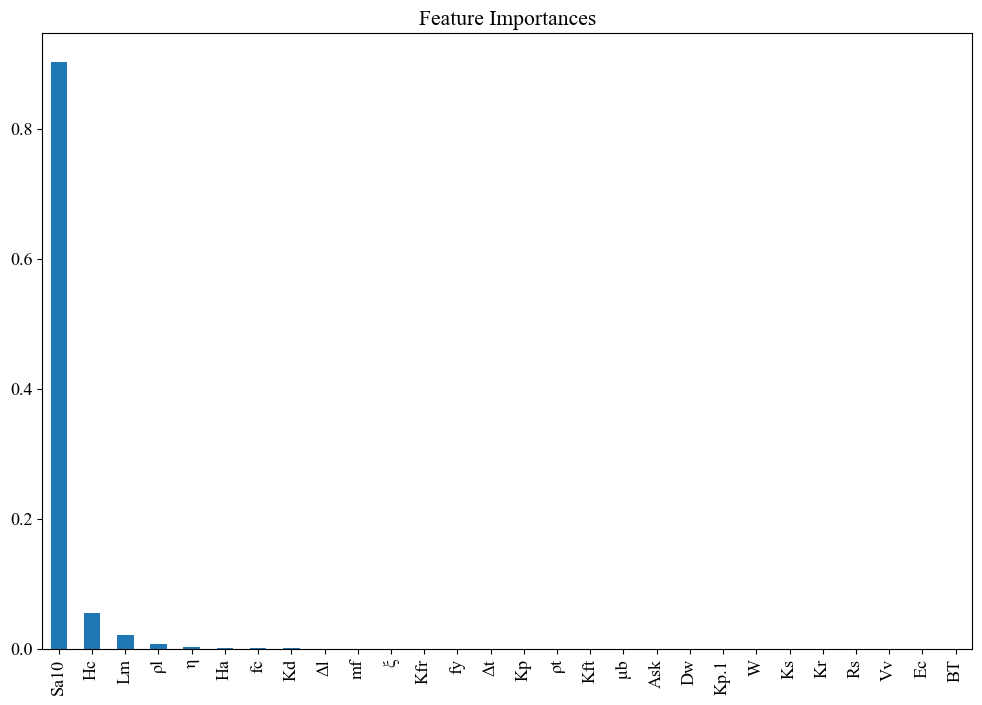

In [19]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 13
# Ensure parameter types are correct
params_best['n_estimators'] = int(params_best['n_estimators'])
params_best['max_depth'] = int(params_best['max_depth'])
params_best['num_leaves'] = int(params_best['num_leaves'])
params_best['bagging_freq'] = int(params_best['bagging_freq'])

# Validate best parameters
reg_best = lgb.LGBMRegressor(**params_best, verbose=-1)
reg_best.fit(X_train, y_train)
validation_loss = np.mean(cross_validate(
    reg_best, X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=False,
    n_jobs=-1
)['test_score'])

print("\nValidation RMSE with best params:", -validation_loss)

# Feature importance with Random Forest
RFR = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=1412)
RFR.fit(X_train, y_train)
importances = RFR.feature_importances_

# Convert feature importances to a pandas Series
importances_series = pd.Series(importances, index=X_train.columns)

print("\nFeature Importances:")
print(importances_series.sort_values(ascending=False))

# Plot feature importances
plt.figure(figsize=(12, 8))
importances_series.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

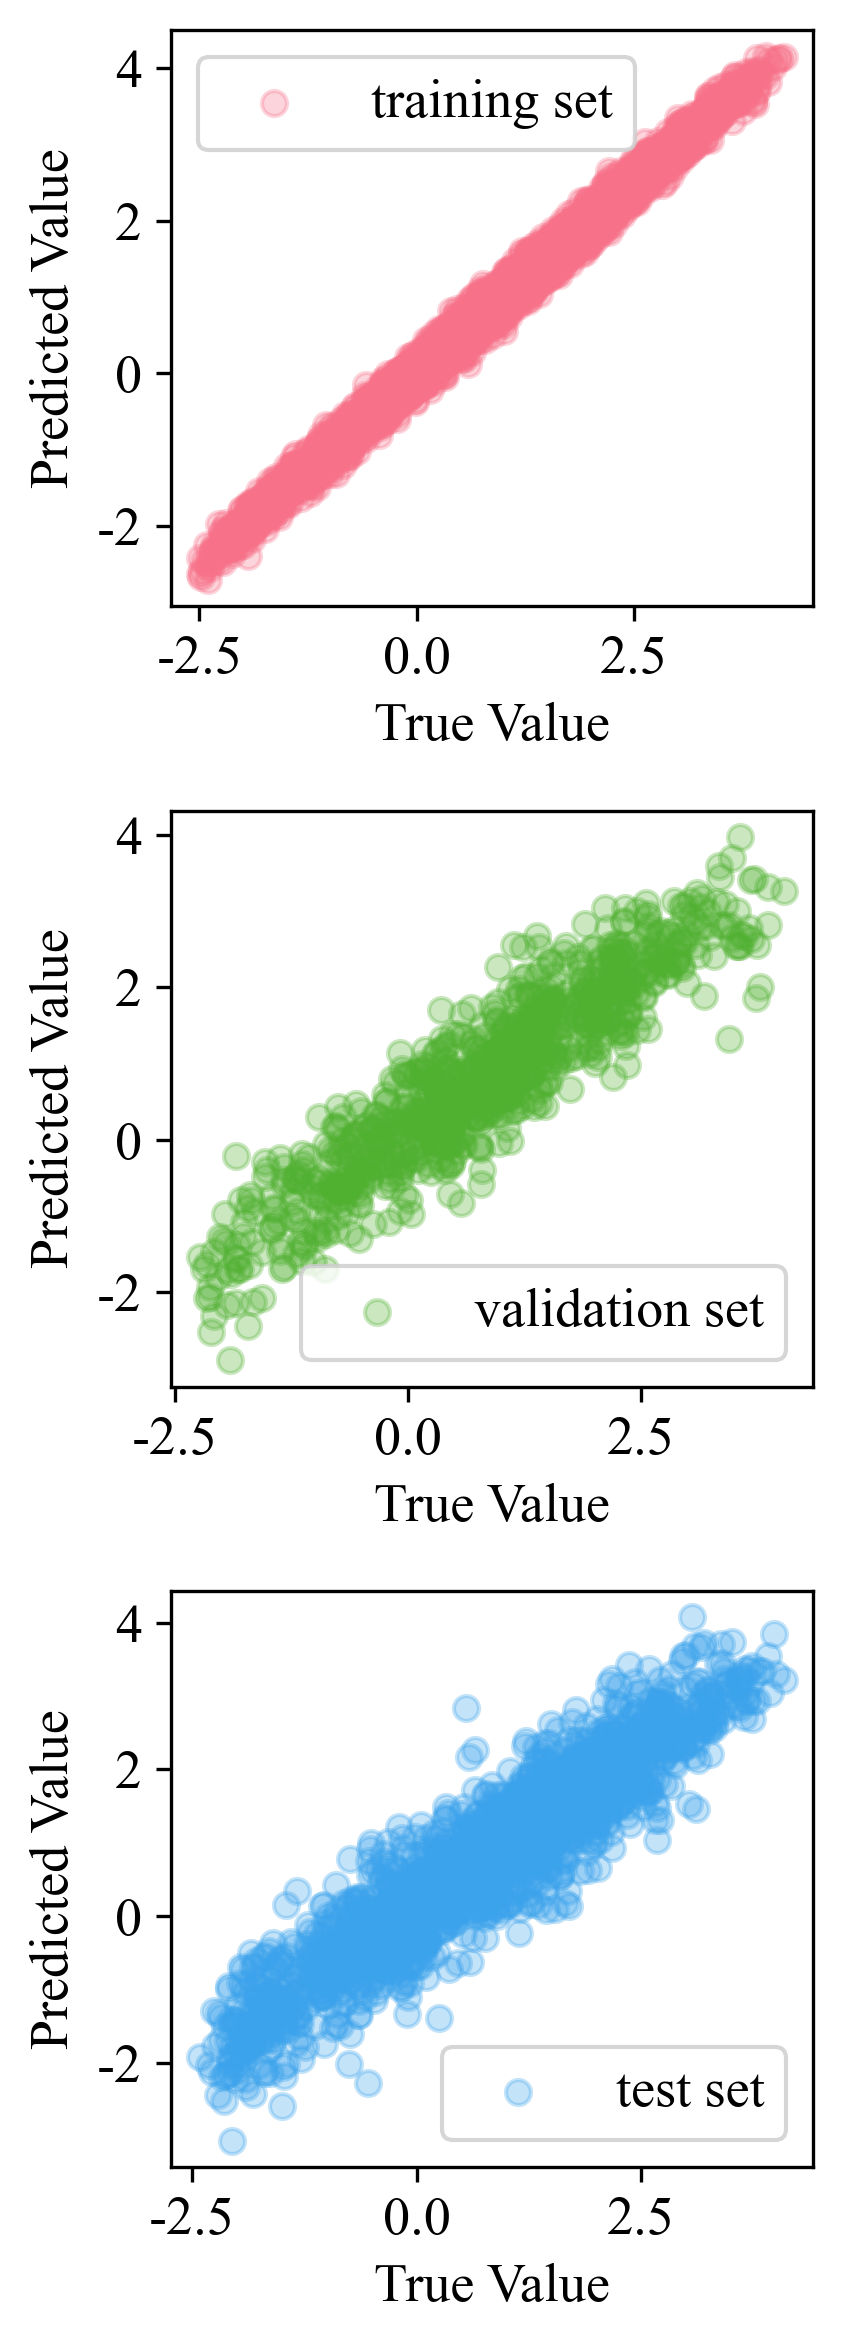

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prediction calculation
pred_train = reg_best.predict(X_train)
pred_val = reg_best.predict(X_val)
pred_test = reg_best.predict(X_test)

# Set global font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Color settings
colors = sns.color_palette("husl", 3)

# Set figure as square-shaped
fig, axs = plt.subplots(3, 1, figsize=(3, 8), dpi=300)

# Training set
axs[0].scatter(y_train, pred_train, label='training set', alpha=0.3, color=colors[0])
axs[0].set_xlabel('True Value')
axs[0].set_ylabel('Predicted Value')
axs[0].legend()

# Validation set
axs[1].scatter(y_val, pred_val, label='validation set', alpha=0.3, color=colors[1])
axs[1].set_xlabel('True Value')
axs[1].set_ylabel('Predicted Value')
axs[1].legend()

# Test set
axs[2].scatter(y_test, pred_test, label='test set', alpha=0.3, color=colors[2])
axs[2].set_xlabel('True Value')
axs[2].set_ylabel('Predicted Value')
axs[2].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


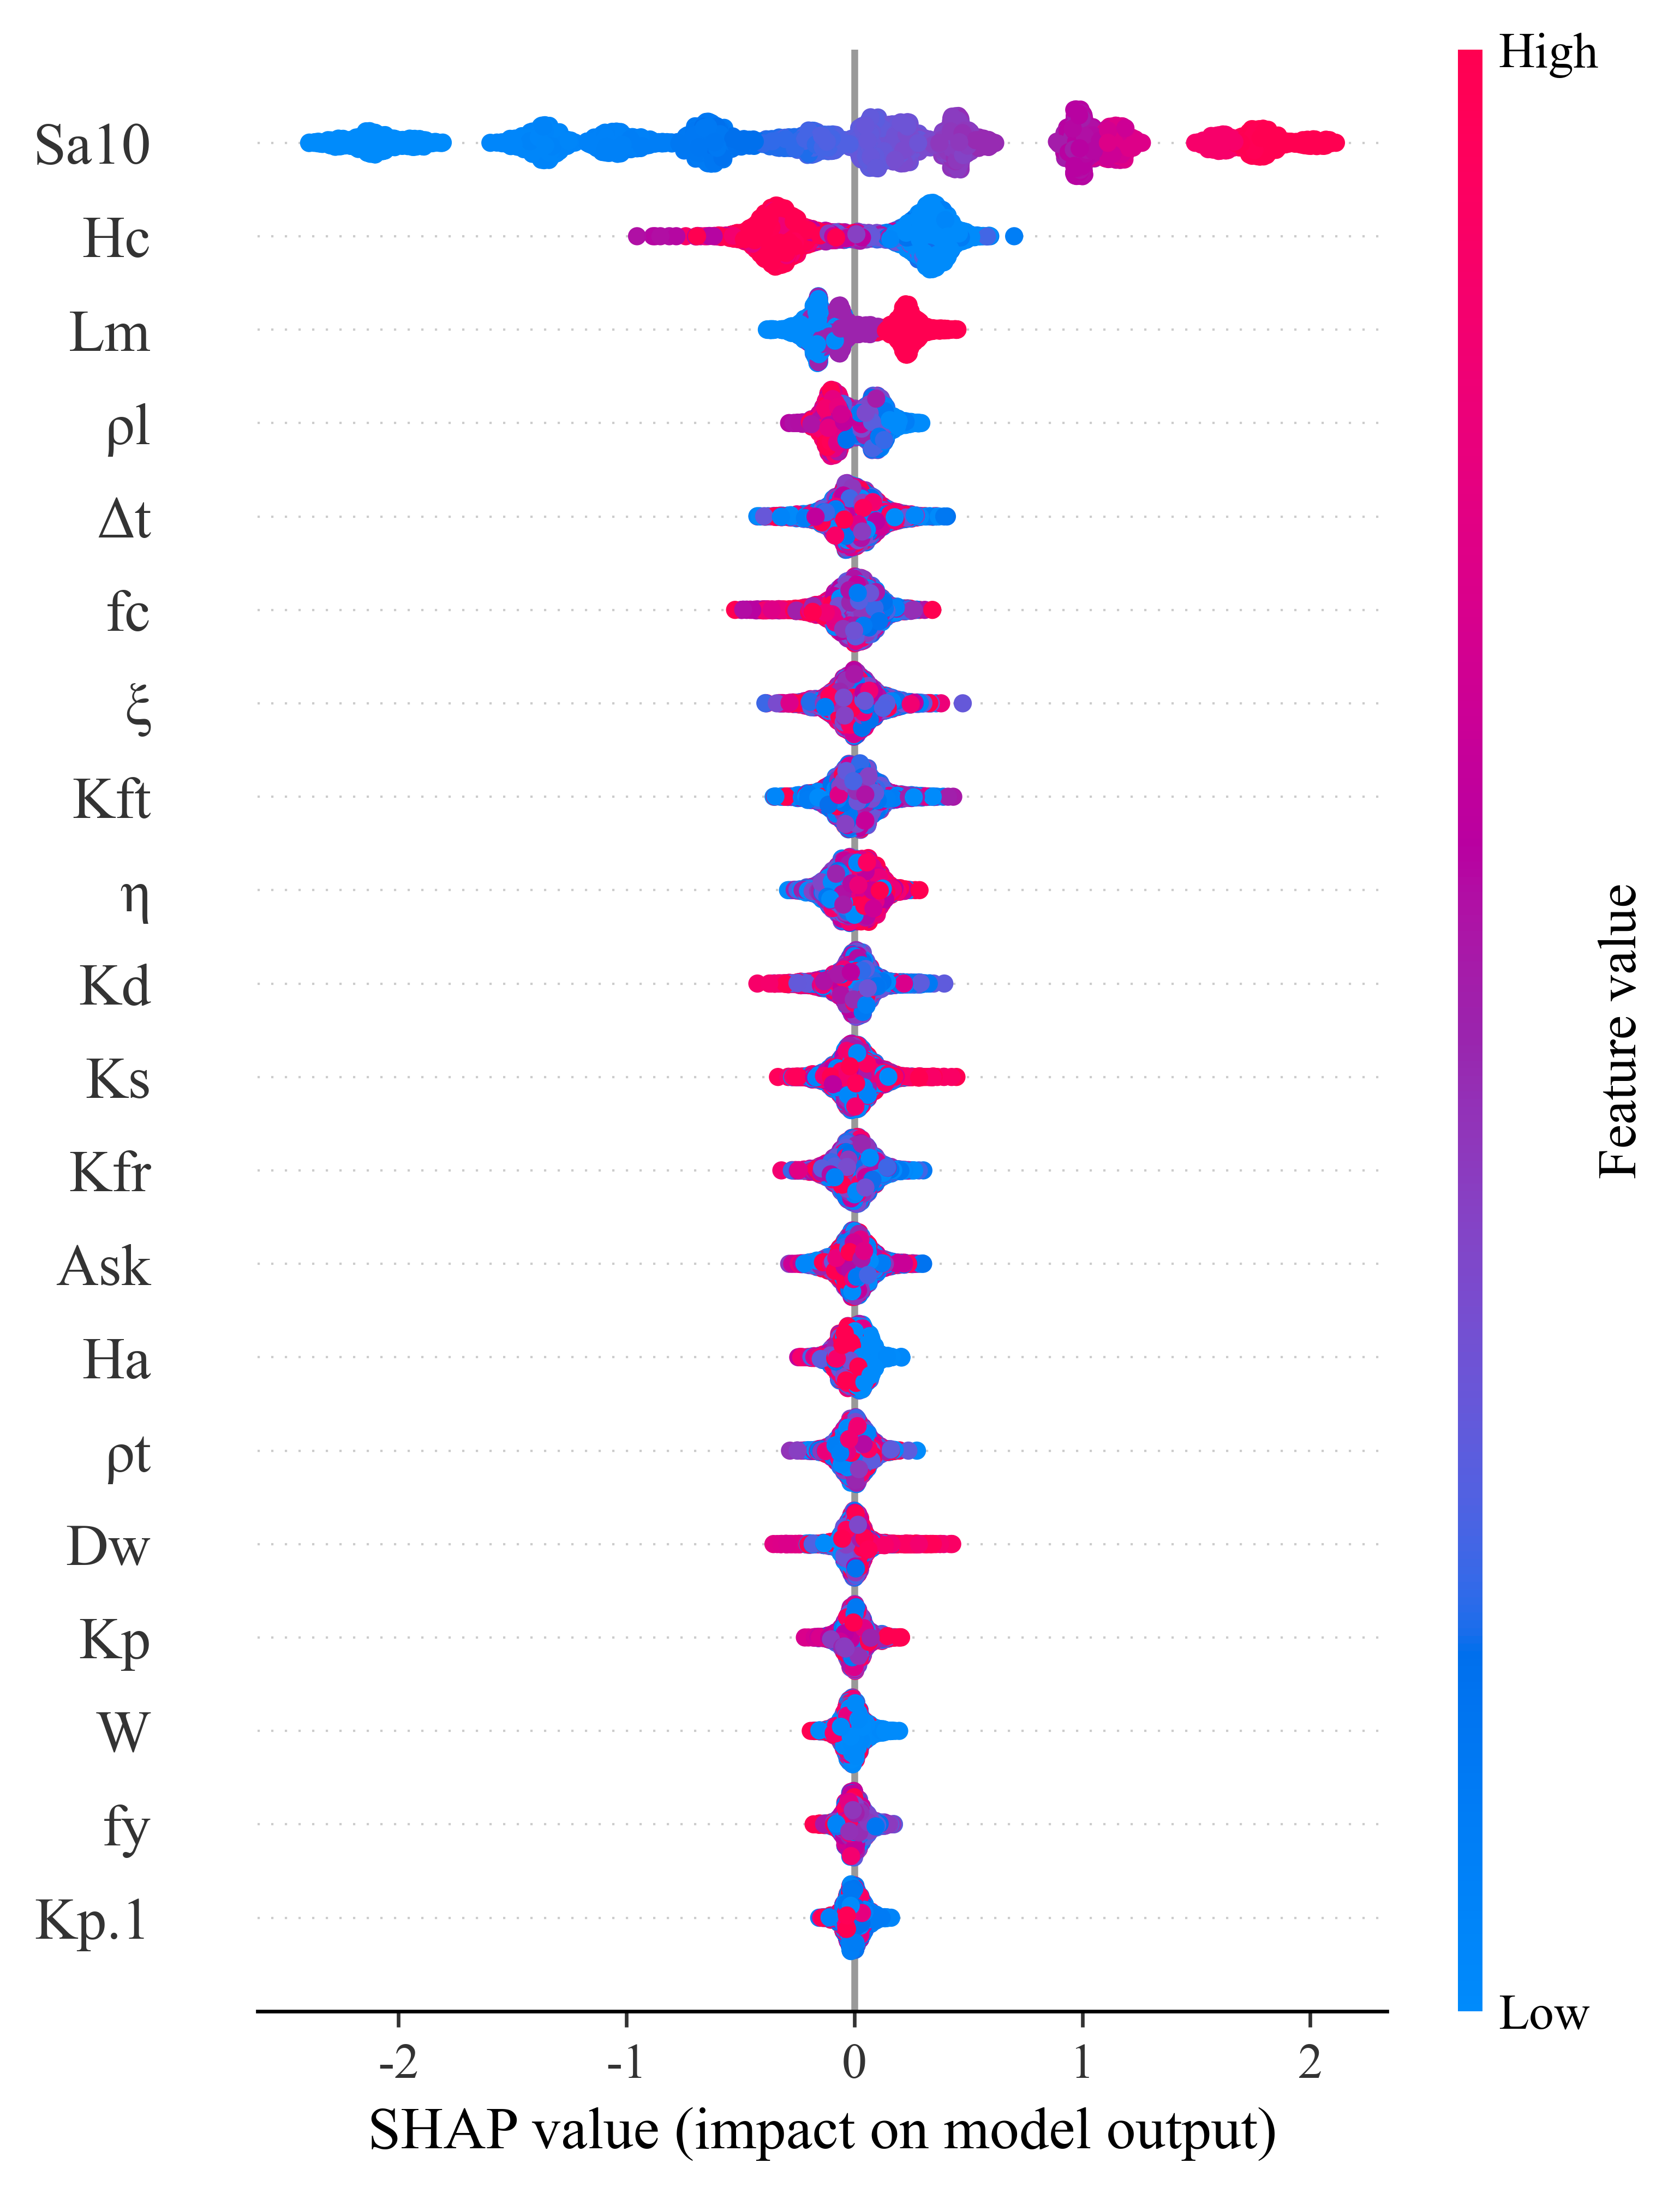

In [21]:
import shap
import matplotlib.pyplot as plt

# Build the SHAP explainer
explainer = shap.TreeExplainer(reg_best)
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
# Feature labels
labels = X_train.columns

# Set font properties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 100

# Create a figure, set the size and resolution
plt.figure(figsize=(10, 8), dpi=600)

# Plot and save the SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=labels, plot_type="dot", show=False)

# Save the plot
plt.savefig('shap_summary_plot.png', bbox_inches='tight')

# Display the plot
plt.show()


In [23]:
print ("shape dimension:", shap_values. shape)
print ("Test Set Dimension:", X_train. shape)

shape dimension: (6048, 28)
Test Set Dimension: (6048, 28)


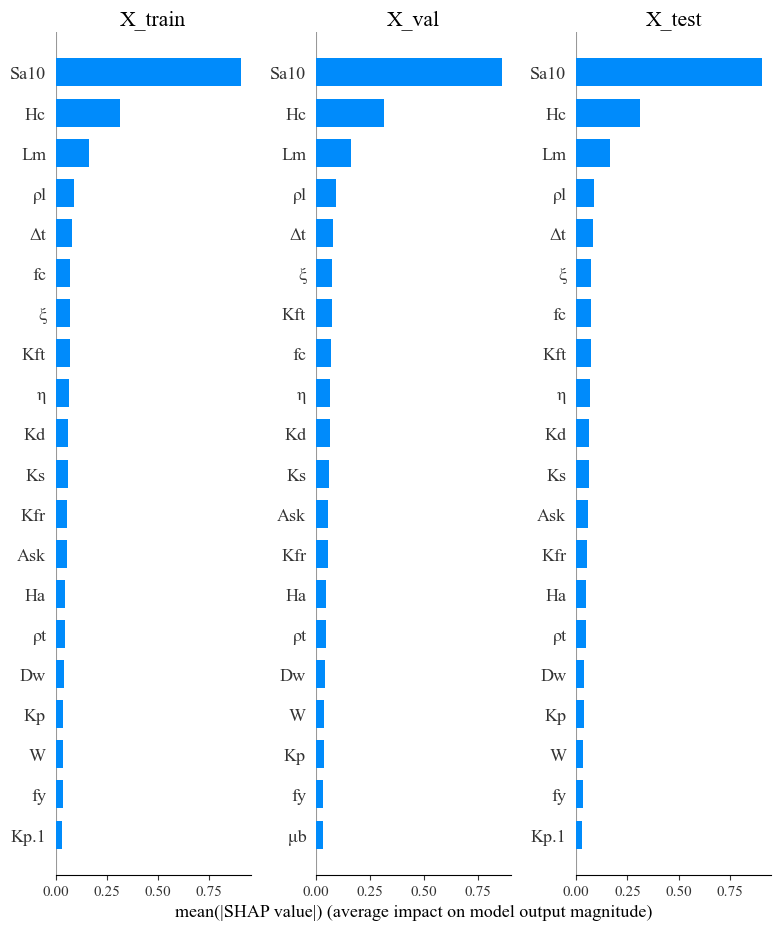

In [24]:
# Set the font style and size for the plot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 13

# Calculate SHAP values for training, validation, and test sets
shap_values_train = explainer.shap_values(X_train)
shap_values_val = explainer.shap_values(X_val)
shap_values_test = explainer.shap_values(X_test)

# Plot the SHAP summary plots for each dataset
plt.figure(figsize=(15, 5))

# SHAP summary plot for training set
plt.subplot(1, 3, 1)
shap.summary_plot(shap_values_train, X_train, plot_type="bar", show=False)
plt.title("X_train")
plt.xlabel('')  # Remove x-axis label to avoid overlap

# SHAP summary plot for validation set
plt.subplot(1, 3, 2)
shap.summary_plot(shap_values_val, X_val, plot_type="bar", show=False)
plt.title("X_val")

# SHAP summary plot for test set
plt.subplot(1, 3, 3)
shap.summary_plot(shap_values_test, X_test, plot_type="bar", show=False)
plt.title("X_test")
plt.xlabel('')  # Remove x-axis label to avoid overlap

plt.tight_layout()
# Save the figure
plt.savefig('shap_summary_plot2.png', bbox_inches='tight')

# Display the plot
plt.show()


<Figure size 640x480 with 0 Axes>

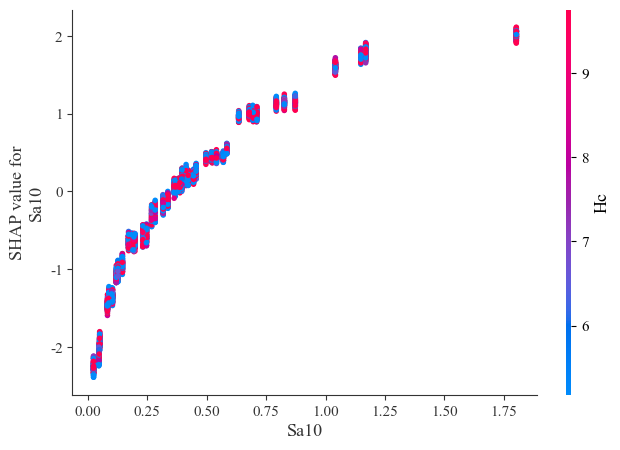

<Figure size 640x480 with 0 Axes>

In [28]:
# Demonstrate using the test set
np.abs(shap_values_train).mean(axis=0)

# Use the test set for demonstration
import numpy as np
import matplotlib.pyplot as plt

# Create a new figure
plt.figure()

# Generate the SHAP dependence plot
shap.dependence_plot('Sa10', shap_values, X_train, interaction_index='Hc')

# Save the figure
plt.savefig('shap_summary_plot3.png', bbox_inches='tight')

# Show the plot
plt.show()

# Close the plot
plt.close()


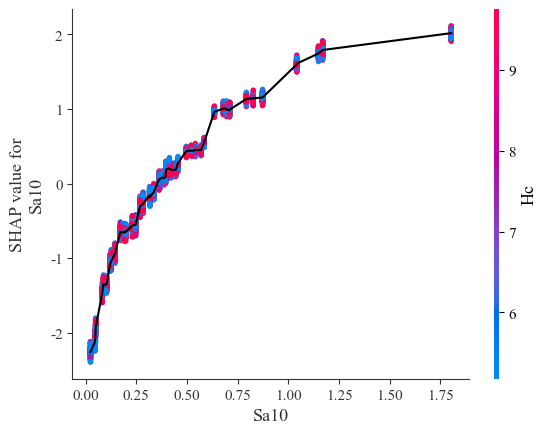

<Figure size 640x480 with 0 Axes>

In [31]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Set font style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 13

# Define feature names (if using DataFrame, ensure they match X_train)
feature_names = X_train.columns.tolist()

# Create a new figure object
fig, ax = plt.subplots()
# i-th feature dependency explanation
i=0

# Calculate average SHAP values
feature_index = i  # Index of the feature to plot
shap_values_for_feature = shap_values[:, feature_index]
feature_values = X_train.iloc[:, feature_index].values

# Calculate the average SHAP value for each feature value
unique_feature_values = np.unique(feature_values)
mean_shap_values = [shap_values_for_feature[feature_values == val].mean() for val in unique_feature_values]

# Plot the average SHAP values on the same figure object
ax.plot(unique_feature_values, mean_shap_values, color='black', linestyle='-', label='Average SHAP Value')

# Draw the SHAP dependence plot
shap.dependence_plot(
    i,                     # Index of the feature to plot
    shap_values,           # SHAP values
    X_train,               # Feature dataset
    feature_names=feature_names,  # Feature names for labeling
    interaction_index='Hc',    
    ax=ax                  # Specify the figure object to plot on
)
# Add legend
ax.legend()

# Save the figure (optional)
plt.savefig('shap_dependence_plot_with_avg_line.png', bbox_inches='tight')

# Display the figure
plt.show()


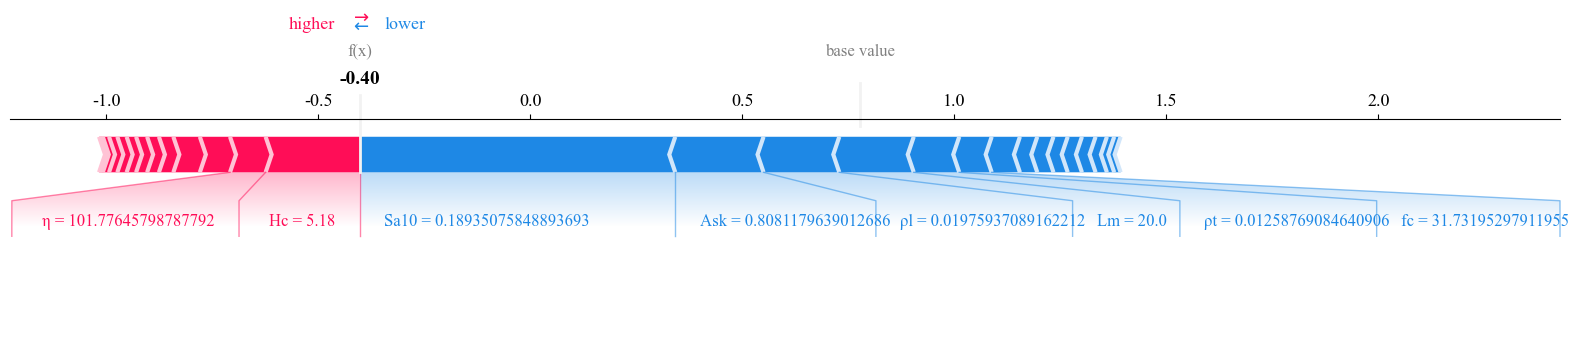

In [29]:
# Plot the SHAP explanation for a single sample (Force Plot)
sample_index = 120  # Select a sample index for interpretation
shap.force_plot(explainer.expected_value, shap_values_test[sample_index], X_test.iloc[sample_index], matplotlib=True)


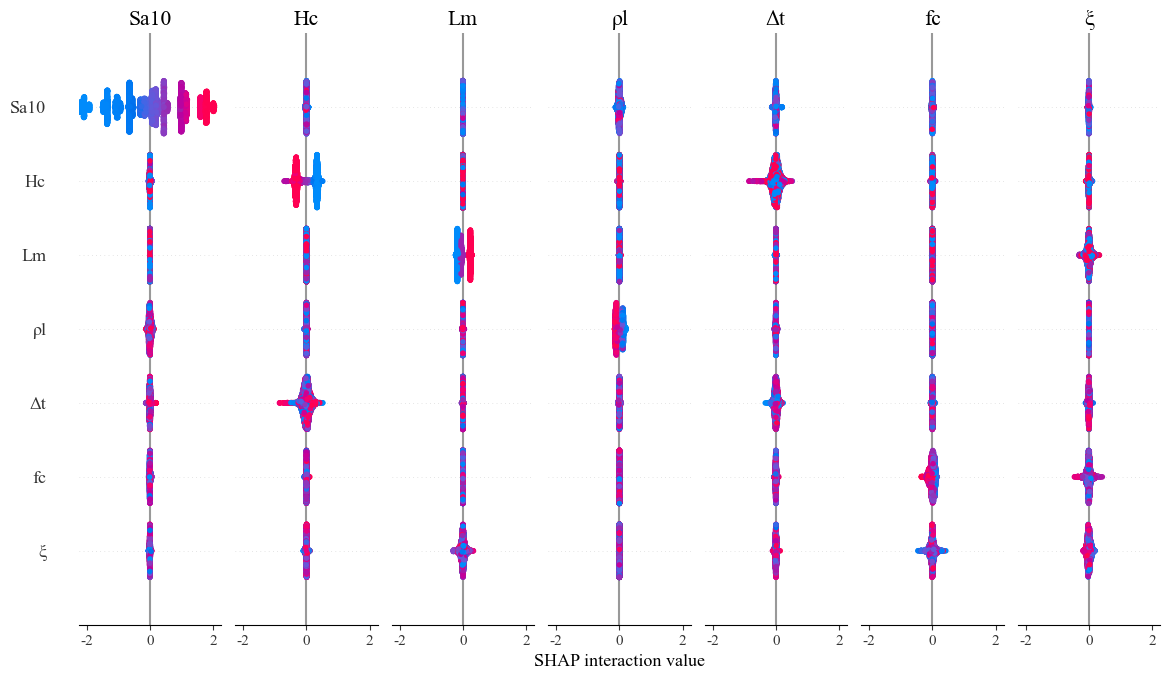

In [30]:
# Calculate SHAP interaction values for the training data
shap_interaction_values = explainer.shap_interaction_values(X_train)

# Generate a summary plot to visualize SHAP interaction values
shap.summary_plot(shap_interaction_values, X_train)
